### **BANK LOAN APPROVAL ANALYSIS**

In [1]:
# ignore all warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import uuid
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV

# Models
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle

# Evaluation Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import recall_score, precision_score, f1_score

#### **1. DATA COLLECTION**

In [3]:
df = pd.read_csv("data/bank.csv")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


#### **2. DATA CLEANING**

In [4]:
# checking the dataset size and the number of nulls and duplicates in the datasets
def data_info(data):
    print("Data Size:", data.shape)
    print("Number of Nulls:")
    print(data.isna().sum())
    print("Number of Duplicates:",data.duplicated().sum())

In [5]:
data_info(df)

Data Size: (11162, 17)
Number of Nulls:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64
Number of Duplicates: 0


In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


- Dataset contains no nulls or duplicates so data cleaning is not required
- There are 11162 rows and 17 columns
- Dateset consists of categorical and numerical features

#### **3. EXPLORATORY DATA ANALYSIS**

#### **3.1. Numerical Features**

In [8]:
# pair plot looking at the relationship between numerical features
def pair_plot(data, hue, filename="pairplot_output.png"):
    # Create the pairplot
    pairplot = sns.pairplot(data=data, hue=hue, height=1.9)
    
    # Save the plot as an image
    pairplot.savefig(filename)
    
    # Show the plot
    plt.show()

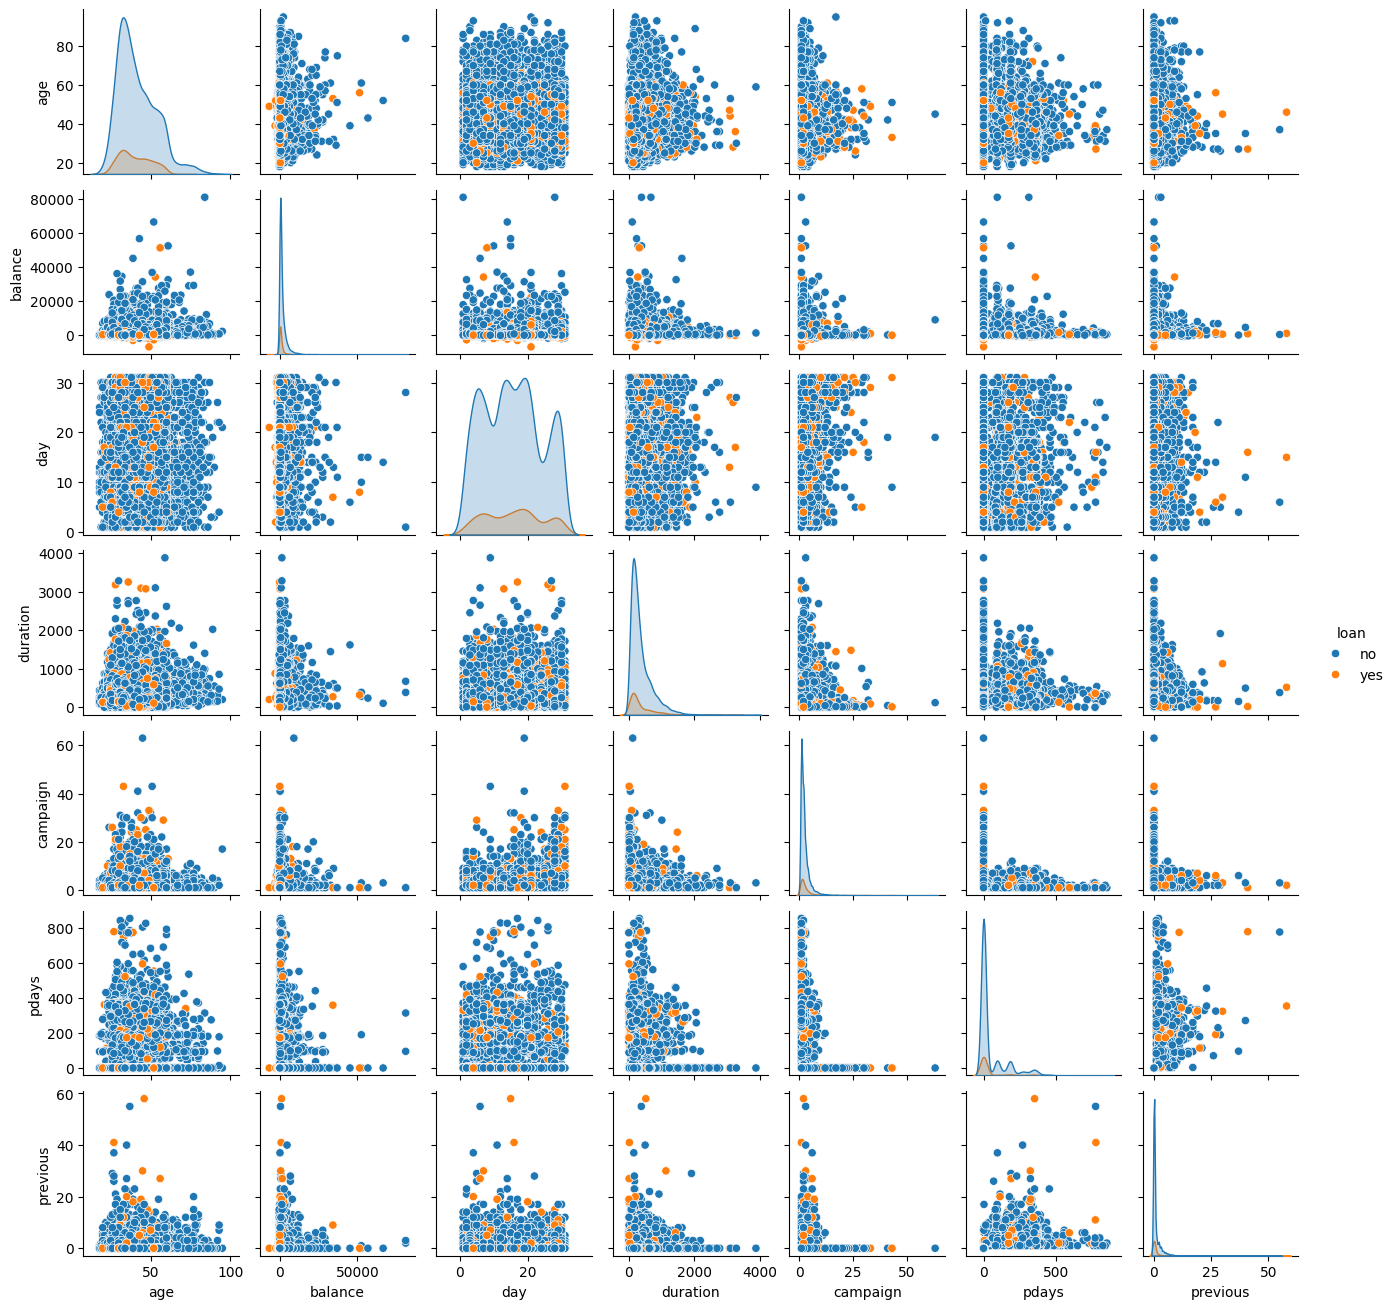

In [9]:
pair_plot(df, "loan");

- The day feature has no impact on bank loan approval because the approval status is distributed fairly for all days. Therefore, this feature will be removed as it will have no impact the loan status.

In [10]:
# retrieving numerical features
df_num = df[["age", "balance", "duration","campaign","pdays","previous"]]

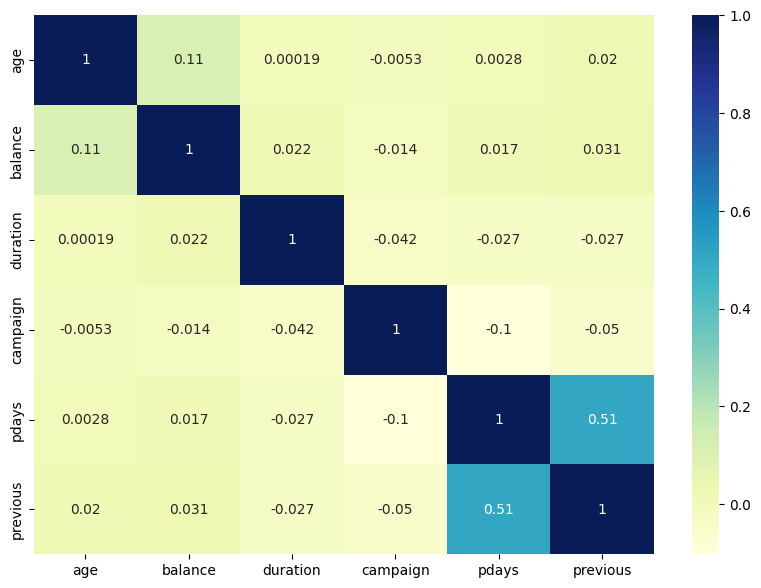

In [11]:
# correlation
plt.figure(figsize=(10,7))
sns.heatmap(df_num.corr(), annot=True, cmap="YlGnBu");

- pday and previous features have a high positive correlation with each other. Therefore one of the features will be removed.

#### **3.2. Categorical Features**

In [12]:
# plot categorical features using barplot
def countplot_multiple(columns, hue, data):
    num_cols = len(columns)
    
    # Create subplots with 1 row and num_cols columns
    fig, axes = plt.subplots(1, num_cols, figsize=(4 * num_cols, 5), sharey=False)
    
    # If there's only one column, handle it separately
    if num_cols == 1:
        sns.countplot(x=columns[0], hue=hue, data=data, ax=axes)
        sns.move_legend(axes, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
        axes.set_xticks(axes.get_xticks())
        axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
    else:
        for idx, col in enumerate(columns):
            ax = sns.countplot(x=col, hue=hue, data=data, ax=axes[idx])
            sns.move_legend(ax, bbox_to_anchor=(1, 0.5), loc='center left', frameon=False)
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
    plt.tight_layout()
    plt.show()

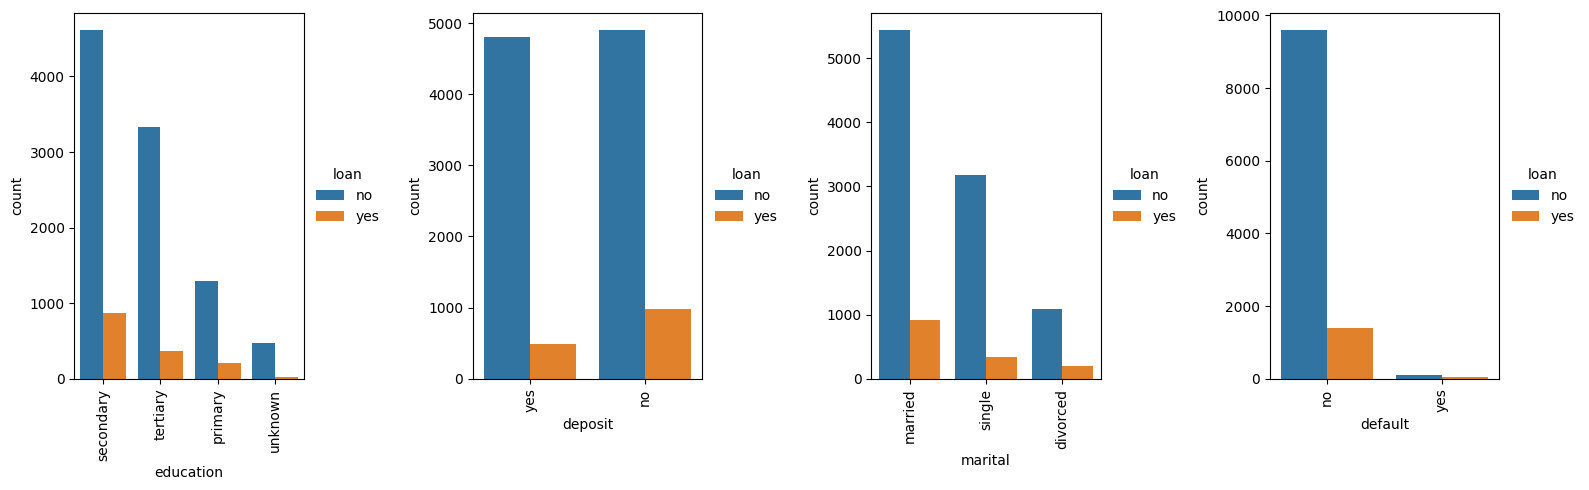

In [13]:
countplot_multiple(['education','deposit','marital','default'],
                   "loan",
                   df)

- default field will be removed because there is not enough data for the approved class.
- education and marital loan approval is based on the number of applications so those fields will be removed.

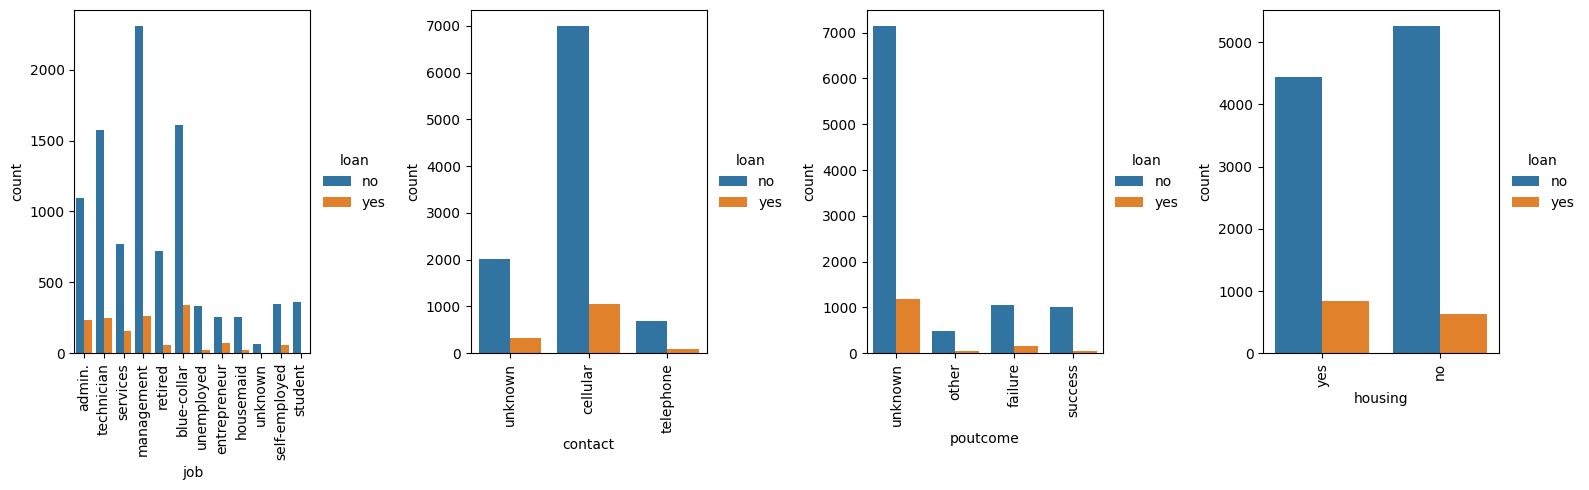

In [14]:
countplot_multiple(['job','contact','poutcome','housing'],
                   "loan",
                   df)

- The most frequent form of contact used was cellure, as a result more loans were approved because of this. So this field will be removed.
- poutcome field consists mostly of unknowns so this field will also be removed during feature engineering.

In [15]:
# line plot to analyse bank loan approvals by month
def line_plot(data, date, legend):

    # Define the order of months explicitly to avoid plotting errors
    month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

    # Convert 'month' to lowercase to match the order list
    data[date] = data[date].str.lower()

    # Filter the data to include only valid month names
    data = data[data[date].isin(month_order)]

    # Convert 'month' to a categorical variable with the defined order
    data[date] = pd.Categorical(data[date], categories=month_order, ordered=True)

    # Group the data by 'month' and 'loan', then count the occurrences
    month_loan_counts = df.groupby([date, legend]).size().reset_index(name='count')

    # Convert the data into separate lines for 'loan' categories
    months = np.array(month_order)  # Convert to NumPy array
    loan_yes_counts = month_loan_counts[month_loan_counts[legend] == 'yes'].set_index(date).reindex(months)['count'].fillna(0).to_numpy()
    loan_no_counts = month_loan_counts[month_loan_counts[legend] == 'no'].set_index(date).reindex(months)['count'].fillna(0).to_numpy()

    # Plot the line graph
    plt.figure(figsize=(12, 6))
    plt.plot(months, loan_no_counts, marker='o', label='Loan: No', color='#4682B4')
    plt.plot(months, loan_yes_counts, marker='o', label='Loan: Yes', color='#D2691E')
    
    # Set plot labels and title
    plt.xlabel(date)
    plt.ylabel('Count')
    plt.title('Bank Loan Approval by Month')
    plt.legend()

    # Show the plot
    plt.show()


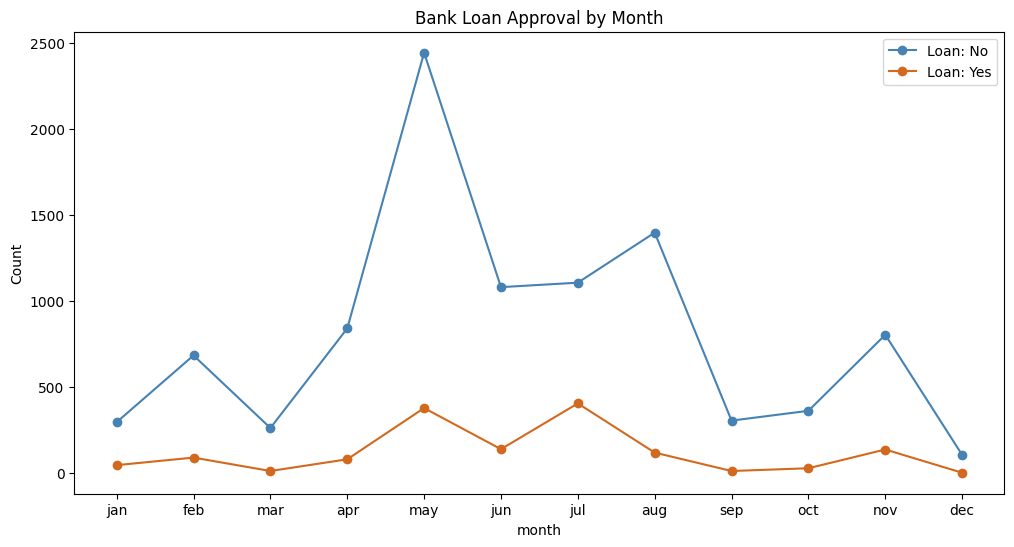

In [16]:
line_plot(df, "month", 'loan')

- bank loans are likely to be approved in July because the number of approvals is higher even though the number of applications is lower compared to other months.
- most bank loan applications are made in May.
- December has the least amount of bank loan applications.

#### **4. FEATURE ENGINEERING**

#### **4.1. Removal and Addition of Features**

In [17]:
# selecting final features to be used during model training
df_final = df[['age','pdays','balance','duration','campaign','job','month','deposit','housing','loan']]

In [18]:
df_final

,age,pdays,balance,duration,campaign,job,month,deposit,housing,loan
0,59,-1,2343,1042,1,admin.,may,yes,yes,no
1,56,-1,45,1467,1,admin.,may,yes,no,no
2,41,-1,1270,1389,1,technician,may,yes,yes,no
3,55,-1,2476,579,1,services,may,yes,yes,no
4,54,-1,184,673,2,admin.,may,yes,no,no
...,...,...,...,...,...,...,...,...,...,...
11157,33,-1,1,257,1,blue-collar,apr,no,yes,no
11158,39,-1,733,83,4,services,jun,no,no,no
11159,32,-1,29,156,2,technician,aug,no,no,no
11160,43,172,0,9,2,technician,may,no,no,yes


In [19]:
# autogenerate and add client id field to dataframe
df_final['client_id'] = [random.randint(100000, 999999) for _ in range(len(df))]

In [20]:
df_final

,age,pdays,balance,duration,campaign,job,month,deposit,housing,loan,client_id
0,59,-1,2343,1042,1,admin.,may,yes,yes,no,202370
1,56,-1,45,1467,1,admin.,may,yes,no,no,184039
2,41,-1,1270,1389,1,technician,may,yes,yes,no,289120
3,55,-1,2476,579,1,services,may,yes,yes,no,703939
4,54,-1,184,673,2,admin.,may,yes,no,no,446494
...,...,...,...,...,...,...,...,...,...,...,...
11157,33,-1,1,257,1,blue-collar,apr,no,yes,no,479710
11158,39,-1,733,83,4,services,jun,no,no,no,838213
11159,32,-1,29,156,2,technician,aug,no,no,no,657168
11160,43,172,0,9,2,technician,may,no,no,yes,874010


- Since there is not client id field and example data is being used, this field will be autogenerated, because once a bank loan status has been predicted, the results need to be mapped back to the client.

#### **4.2. Categorical Dependent Variable Balance**

In [21]:
# comparing the number of approved vs not approved loans
loan_status = pd.value_counts(df_final["loan"], sort=True).sort_index()
print(loan_status)

no     9702
yes    1460
Name: loan, dtype: int64


In [22]:
def pie_chart_plot(num_yes, num_no, explode, title):

    # creating a pie chart plot
    plt.figure(figsize=(10,5))
    size = [num_yes, num_no]
    labels = ['yes', 'no']
    colors = ['#D2691E', '#4682B4']
    explode = explode

    plt.pie(size, colors = colors, labels = labels, shadow = True, explode = explode, autopct = '%.2f%%')
    plt.title(title, fontsize = 20)
    plt.legend()
    plt.show() 

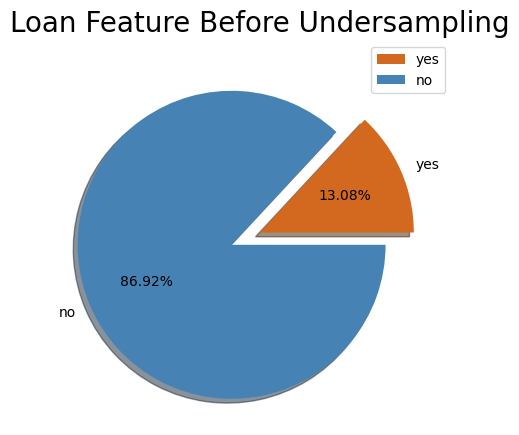

In [23]:
pie_chart_plot(1460,9702,[0, 0.2], 'Loan Feature Before Undersampling')

In [24]:
# Creating an undersampler object
rus = RandomUnderSampler(random_state=2)

X = df_final.drop("loan", axis=1)
y = df_final["loan"]

# Resample the features for training data and the target
X_sampled, y_sampled = rus.fit_resample(X,y)

    # Revert resampled data into dataframe
X_sampled = pd.DataFrame(X_sampled)
y_sampled = pd.DataFrame(y_sampled)

X_sampled.shape
y_sampled.shape

undersampled_df = pd.concat([X_sampled, y_sampled], axis=1)

undersampled_df.shape


(2920, 11)

In [25]:
loan_status_sampled = pd.value_counts(undersampled_df["loan"], sort=True).sort_index()
print(loan_status_sampled)

no     1460
yes    1460
Name: loan, dtype: int64


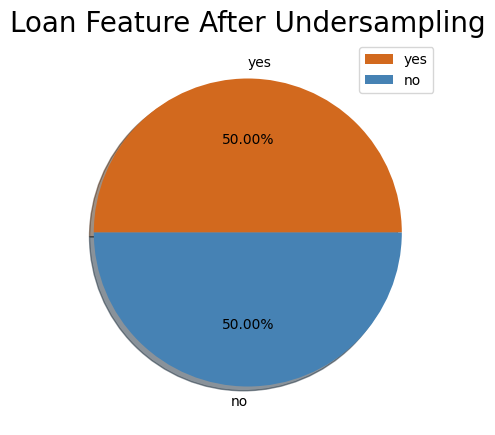

In [26]:
pie_chart_plot(1460,1460,[0, 0],'Loan Feature After Undersampling')

- since there was an imbalance between approved and not approved bank loans, undersampling had to be applied so that the model will not be biased.
- undersampling was chosen over oversampling to ensure the data remains accurate and having ~3000 rows of data is still a good sample.

In [27]:
undersampled_df[undersampled_df["job"] == 'housemaid'].head()

,age,pdays,balance,duration,campaign,job,month,deposit,housing,client_id,loan
10131,43,-1,24,35,2,housemaid,jul,no,no,879399,no
249,41,-1,879,1053,2,housemaid,jun,yes,no,176855,no
6655,57,-1,260,38,3,housemaid,may,no,yes,464959,no
7281,36,-1,622,55,5,housemaid,jun,no,no,486884,no
248,56,-1,1238,1558,1,housemaid,jun,yes,no,388386,no


In [28]:
undersampled_df.to_csv("data_2.csv")

In [29]:
# Convert categorical features to numeric using label encoder
le = LabelEncoder()

# Apply le on categorical feature columns
undersampled_df[['job', 'month', 'deposit', 'housing', 'loan']] = undersampled_df[['job', 
                                                                                    'month', 
                                                                                    'deposit', 
                                                                                    'housing',  
                                                                                    'loan']].apply(lambda col: le.fit_transform(col))

In [30]:
undersampled_df[undersampled_df["job"] == 3].head()

,age,pdays,balance,duration,campaign,job,month,deposit,housing,client_id,loan
10131,43,-1,24,35,2,3,5,0,0,879399,0
249,41,-1,879,1053,2,3,6,1,0,176855,0
6655,57,-1,260,38,3,3,8,0,1,464959,0
7281,36,-1,622,55,5,3,6,0,0,486884,0
248,56,-1,1238,1558,1,3,6,1,0,388386,0


#### **5. CLASSIFICATION MODELS**

In [31]:
# splitting data into independent variables and dependent variable and testing and training set.

X = undersampled_df.drop("loan", axis=1)
y = undersampled_df["loan"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [32]:
# training machine learning model
def train_ml_model(model):
    # ensure model results remain the same when re-running code
    np.random.seed(42)

    classifier = model
    trained_c = classifier.fit(X_train, y_train)

    return trained_c

#### **5.1. Random Forest Classifier**

In [33]:
np.random.seed(42)

In [34]:
rf_trained = train_ml_model(RandomForestClassifier())

In [35]:
# make predictions
y_pred_rf = rf_trained.predict(X_test)

#### **5.2. KNN**

In [36]:
knn_trained = train_ml_model(KNeighborsClassifier())

In [37]:
# make predictions
y_pred_knn = knn_trained.predict(X_test)

#### **5.3. SVC**

In [38]:
svc_trained = train_ml_model(SVC())

In [39]:
# make predictions
y_pred_svc = svc_trained.predict(X_test)

#### **5.4. Logistic Regression**

In [40]:
lr_trained = train_ml_model(LogisticRegression())

In [41]:
# make predictions
y_pred_lr = lr_trained.predict(X_test)

#### **6. EVALUATION OF MODEL PERFORMANCE**

#### **6.1. Confusion Matrix**

In [42]:
cm_rf = confusion_matrix(y_test,y_pred_rf)
cm_knn = confusion_matrix(y_test,y_pred_knn)
cm_svc = confusion_matrix(y_test,y_pred_svc)
cm_lr = confusion_matrix(y_test,y_pred_lr)

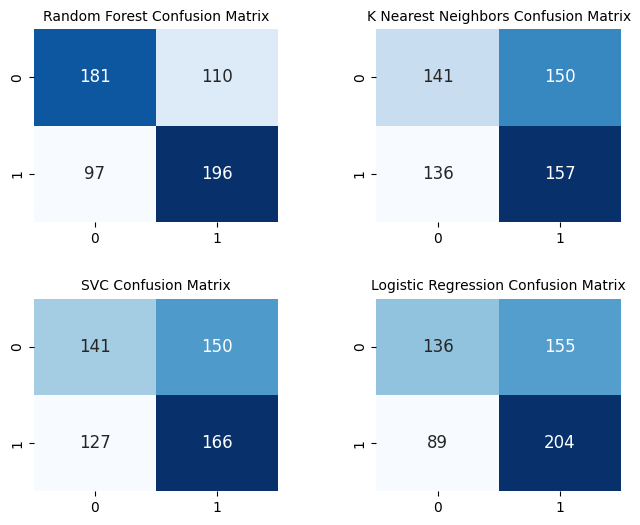

In [43]:
# plotting confusion matrix
plt.figure(figsize=(12,6))

# plt.suptitle("Confusion Matrixes",fontsize=24)
plt.subplots_adjust(wspace = 0.4, hspace= 0.4)

plt.subplot(2,3,1)
plt.title("Random Forest Confusion Matrix", fontsize=10)
sns.heatmap(cm_rf,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 12})

plt.subplot(2,3,2)
plt.title("K Nearest Neighbors Confusion Matrix", fontsize=10)
sns.heatmap(cm_knn,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 12})


plt.subplot(2,3,4)
plt.title("SVC Confusion Matrix", fontsize=10)
sns.heatmap(cm_svc,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 12})

plt.subplot(2,3,5)
plt.title("Logistic Regression Confusion Matrix", fontsize=10)
sns.heatmap(cm_lr,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 12});

#### **6.2. Accuracy Score**

In [44]:
scores = {}

In [45]:
acc_rf = accuracy_score(y_test, y_pred_rf)
scores['Random Forest'] = acc_rf
acc_knn = accuracy_score(y_test, y_pred_knn)
scores['KNN'] = acc_knn
acc_svc = accuracy_score(y_test, y_pred_svc)
scores['SVC'] = acc_svc
acc_lr = accuracy_score(y_test, y_pred_lr)
scores['Logistic Regression'] = acc_lr
print(acc_rf, acc_knn, acc_svc, acc_lr)

0.6455479452054794 0.5102739726027398 0.5256849315068494 0.5821917808219178


0.6455479452054794 0.5102739726027398 0.5256849315068494 0.5821917808219178


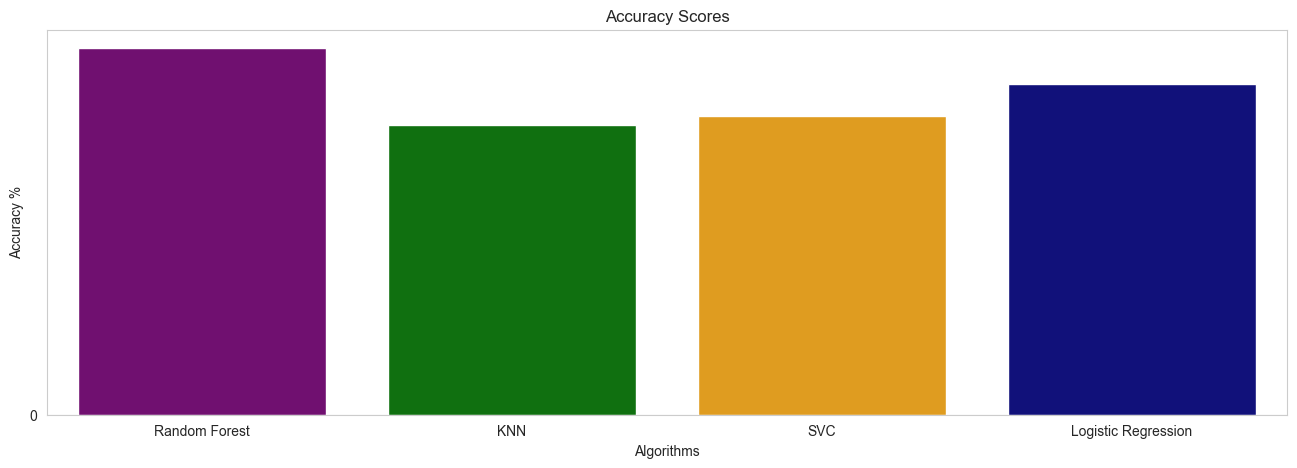

In [46]:
print(acc_rf, acc_knn, acc_svc, acc_lr)
# plot accuracy scores
colors = ["purple", "green", "orange", "darkblue"]

sns.set_style("whitegrid")
plt.figure(figsize=(16,5))
plt.yticks(np.arange(0,100,10))
plt.ylabel("Accuracy %")
plt.xlabel("Algorithms")
sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette=colors)
plt.title("Accuracy Scores")
plt.show()

#### **6.3. Classification Report**

In [47]:
# creating classification report
def classification_r(prediction):
    target_names = ["Loan Not Approved", "Loan Approved"]
    print(classification_report(y_test, prediction, target_names=target_names))

In [48]:
# Random Forest
classification_r(y_pred_rf)

                   precision    recall  f1-score   support

Loan Not Approved       0.65      0.62      0.64       291
    Loan Approved       0.64      0.67      0.65       293

         accuracy                           0.65       584
        macro avg       0.65      0.65      0.65       584
     weighted avg       0.65      0.65      0.65       584



In [49]:
# KNN
classification_r(y_pred_knn)

                   precision    recall  f1-score   support

Loan Not Approved       0.51      0.48      0.50       291
    Loan Approved       0.51      0.54      0.52       293

         accuracy                           0.51       584
        macro avg       0.51      0.51      0.51       584
     weighted avg       0.51      0.51      0.51       584



In [50]:
# SVC
classification_r(y_pred_svc)

                   precision    recall  f1-score   support

Loan Not Approved       0.53      0.48      0.50       291
    Loan Approved       0.53      0.57      0.55       293

         accuracy                           0.53       584
        macro avg       0.53      0.53      0.52       584
     weighted avg       0.53      0.53      0.52       584



In [51]:
# Logistic Regression
classification_r(y_pred_lr)

                   precision    recall  f1-score   support

Loan Not Approved       0.60      0.47      0.53       291
    Loan Approved       0.57      0.70      0.63       293

         accuracy                           0.58       584
        macro avg       0.59      0.58      0.58       584
     weighted avg       0.59      0.58      0.58       584



#### **7. MODEL IMPROVEMENT**

#### **7.1. Hyperparameter Tuning for best performing model**

In [52]:
# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80,90,100,110],
#     'max_features': [2,3],
#     'min_samples_leaf': [3,4,5],
#     'min_samples_split': [8,10,12],
#     'n_estimators': [100,200,300,1000]
# }

# grid_rf = GridSearchCV(estimator = rf,
#                        param_grid=param_grid,
#                        cv=3,
#                        n_jobs=-1,
#                        verbose=2)

In [53]:
# grid_rf.fit(X_train, y_train)
# grid_rf.best_params_

# grid_rf.score(X_test,y_test)
# rf.score(X_test,y_test)

#### **8. SAVE MODEL**

In [54]:
# Save Random Forest Classifier Model
filename = "bank_loan_approval.pkl"
pickle.dump(rf_trained, open(filename, 'wb'))

In [55]:
# Load model
load_model = pickle.load(open(filename,'rb'))
results = load_model.score(X_test, y_test)
print(results)

0.6455479452054794
